In [1]:
import torch
import numpy as np
import pandas as pd
import pickle
import statistics
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import significantdigits as sd
from significantdigits import Error
import re
import json
from matplotlib.lines import Line2D
import nibabel as nib
from nilearn import plotting
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta


## Runtime

In [30]:
def convert_elapsed_to_seconds(line):
    # Extract the elapsed time using regex
    # match = re.search(r"(\d+):(\d+):(\d+)elapsed", line)
    match = re.search(r"(?:(\d+):)?(\d+):(\d+(?:\.\d+)?)elapsed", line)

    # match = re.search(r'(\d+):(\d+):(\d+(?:\.\d+)?)elapsed', line)
    # if match is None: 
    #     match = re.search(r'(\d+):(\d+(?:\.\d+)?)elapsed', line)

    if match:
        hours = int(match.group(1)) if match.group(1) else 0  # Default to 0 if hours are missing
        minutes = int(match.group(2))
        seconds = float(match.group(3))
        # Convert to seconds
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    else:
        raise ValueError("Elapsed time not found in the input line")



def calculate_time_difference(date1: str, date2: str) -> int:
    # Define the formats for each date
    format1 = "%a %b %d %H:%M:%S %Z %Y"
    format2 = "%Y-%d-%b_%H:%M:%S"

    # Parse the dates into datetime objects
    dt1 = datetime.strptime(date1, format1)
    dt2 = datetime.strptime(date2, format2)
    # print(dt1, dt2)
    # Calculate the difference in seconds
    difference = abs((dt2 - dt1).total_seconds())
    return difference

def calculate_total_seconds(f):

    for line in f: 
        if "EST" in line:    
            start_date = line.strip()
            # print(start_date)

        #Find end date
        if "inference.py:  400" in line:
            line = line.split(']:')[-1].strip()
            # Parse the input date string
            parsed_date = datetime.strptime(line, "%y-%m-%d_%H:%M:%S")

            # Format the date into the desired output format
            end_date = parsed_date.strftime("2024-%d-%b_%H:%M:%S")
            # print(end_date)

            total_seconds = calculate_time_difference(start_date, end_date)
            # print(type(total_seconds), total_seconds)
            return total_seconds


verrou_sr_fastsurfer = []
verrou_ud_fastsurfer = []
fuzzy_sr_fastsurfer = []
fuzzy_ud_fastsurfer = []
ieee_fastsurfer = []

for iter in range(1,6):
    time_per_sub_verrou_sr = []
    time_per_sub_verrou_ud = []
    time_per_sub_fuzzy_sr = []
    time_per_sub_fuzzy_ud = []
    time_per_sub_default = []

    # for sub in range(1,6):
    for sub in [1,2,3,5]:
        f = open(f"/home/inesgp/verrou_fastsurfer/slurm/verrou_sr_fastsurfer_{iter}_{sub}.log")
        time_per_sub_verrou_sr.append(calculate_total_seconds(f))

        f = open(f"/home/inesgp/verrou_fastsurfer/slurm/verrou_ud_fastsurfer_v2_{iter}_{sub}.log")
        time_per_sub_verrou_ud.append(calculate_total_seconds(f))

        f = open(f"/home/inesgp/verrou_fastsurfer/slurm/fuzzy_sr_fastsurfer_{iter}_{sub}.log")
        time_per_sub_fuzzy_sr.append(calculate_total_seconds(f))

        # print(iter, sub)
        f = open(f"/home/inesgp/verrou_fastsurfer/slurm/fuzzy_ud_fastsurfer_v2_{iter}_{sub}.log")
        time_per_sub_fuzzy_ud.append(calculate_total_seconds(f))

        f = open(f"/home/inesgp/verrou_fastsurfer/slurm/ieee_single_fastsurfer_v2_{iter}_{sub}.log")
        time_per_sub_default.append(calculate_total_seconds(f))

    


    verrou_sr_fastsurfer.append(time_per_sub_verrou_sr)
    verrou_ud_fastsurfer.append(time_per_sub_verrou_ud)
    fuzzy_sr_fastsurfer.append(time_per_sub_fuzzy_sr)
    fuzzy_ud_fastsurfer.append(time_per_sub_fuzzy_ud)
    ieee_fastsurfer.append(time_per_sub_default)

verrou_sr_fastsurfer = np.array(verrou_sr_fastsurfer).mean(axis=1)
verrou_ud_fastsurfer = np.array(verrou_ud_fastsurfer).mean(axis=1)
fuzzy_ud_fastsurfer = np.array(fuzzy_ud_fastsurfer).mean(axis=1)
fuzzy_sr_fastsurfer = np.array(fuzzy_sr_fastsurfer).mean(axis=1)
ieee_fastsurfer = np.array(ieee_fastsurfer).mean(axis=1)

verrou_ud_ratio = [(v/f) for v,f in zip(verrou_ud_fastsurfer, fuzzy_ud_fastsurfer)]
verrou_ud_ratio = np.array(verrou_ud_ratio)
verrou_sr_ratio = [(v/f) for v,f in zip(verrou_sr_fastsurfer, fuzzy_sr_fastsurfer)]
verrou_sr_ratio = np.array(verrou_sr_ratio)



fastsurfer_runtime = pd.DataFrame({'Default': ieee_fastsurfer, 'Verrou CESTAC': verrou_ud_fastsurfer, 'Fuzzy PyTorch UD': fuzzy_ud_fastsurfer, 
                                   'Verrou SR': verrou_sr_fastsurfer, 'Fuzzy PyTorch SR': fuzzy_sr_fastsurfer,
                              "Fuzzy UD Speed Up Factor from Verrou": verrou_ud_ratio, "Fuzzy SR Speed Up Factor from Verrou": verrou_sr_ratio, })

fastsurfer_runtime

,Default,Verrou CESTAC,Fuzzy PyTorch UD,Verrou SR,Fuzzy PyTorch SR,Fuzzy UD Speed Up Factor from Verrou,Fuzzy SR Speed Up Factor from Verrou
0,137.00,9953.50,2095.25,10657.75,144240.50,4.750507,0.073889
1,132.50,9904.75,2198.00,10627.25,144354.75,4.506256,0.073619
2,137.00,9892.25,2203.00,9193.00,145174.75,4.490354,0.063324
3,137.50,10073.75,2279.75,9205.75,142250.00,4.418796,0.064715
4,141.25,10007.00,2228.75,6373.75,146049.00,4.489961,0.043641


In [44]:
# MNIST

# fuzzy_mnist = [] # fuzzy UD multithread
fuzzy_singlethread_ud_mnist = []
fuzzy_singlethread_sr_mnist = []
verrou_ud_mnist = []
verrou_sr_mnist = []
default_mnist = []

for num in range(1,6):
    # f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_{num}.out")
    # for line in f: 
    #     if "real" in line:
    #         time_str = line.split('real')[-1]
    #         minutes, seconds = time_str.split('m')
    #         seconds = float(seconds.replace('s', ''))
    #         total_seconds = int(minutes) * 60 + seconds
    #         fuzzy_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_singlethread_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            fuzzy_singlethread_ud_mnist.append(total_seconds)
    
    f = open(f"/home/inesgp/mnist/slurm/fuzzy_mnist_test_v2_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            fuzzy_singlethread_sr_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/verrou_ud_trace_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            verrou_ud_mnist.append(total_seconds)

    f = open(f"/home/inesgp/mnist/slurm/verrou_sr_trace_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            verrou_sr_mnist.append(total_seconds)


    f = open(f"/home/inesgp/mnist/slurm/default_mnist_test_{num}.out")
    for line in f: 
        if "real" in line:
            time_str = line.split('real')[-1]
            minutes, seconds = time_str.split('m')
            seconds = float(seconds.replace('s', ''))
            total_seconds = int(minutes) * 60 + seconds
            default_mnist.append(total_seconds)

verrou_ud_ratio_singlethread = [(v/f) for v,f in zip(verrou_ud_mnist, fuzzy_singlethread_ud_mnist)]
verrou_sr_ratio_singlethread = [(v/f) for v,f in zip(verrou_sr_mnist, fuzzy_singlethread_sr_mnist)]
# fuzzy_ratio = [(d/f) for f,d in zip(fuzzy_rr_mnist, default_mnist)]

mnist_runtime = pd.DataFrame({'Default': default_mnist,'Verrou UD': verrou_ud_mnist, 'Verrou SR': verrou_sr_mnist, 'Fuzzy UD PyTorch': fuzzy_singlethread_ud_mnist, 'Fuzzy SR PyTorch': fuzzy_singlethread_sr_mnist, 
                              "Fuzzy UD Speed Up Factor from Verrou": verrou_ud_ratio_singlethread, "Fuzzy SR Speed Up Factor from Verrou": verrou_sr_ratio_singlethread, })
mnist_runtime = mnist_runtime.rename(index={0: 'MCA Iteration 1', 1: 'MCA Iteration 2', 2: 'MCA Iteration 3', 3: 'MCA Iteration 4', 4: 'MCA Iteration 5'})

print('Only observing single threaded results')
# print('Average Speed Up Factor: ',mnist_runtime['Speed Up Factor'].mean())
mnist_runtime

Only observing single threaded results


,Default,Verrou UD,Verrou SR,Fuzzy UD PyTorch,Fuzzy SR PyTorch,Fuzzy UD Speed Up Factor from Verrou,Fuzzy SR Speed Up Factor from Verrou
MCA Iteration 1,14.004,4722.666,4801.143,198.860,5154.173,23.748698,0.931506
MCA Iteration 2,14.016,4278.724,4817.184,196.761,5130.386,21.745793,0.938952
MCA Iteration 3,14.013,4276.504,4813.450,200.517,5119.222,21.327389,0.940270
MCA Iteration 4,14.008,4258.391,4960.544,199.072,5217.241,21.391210,0.950798
MCA Iteration 5,13.999,4267.812,4095.451,199.142,5131.316,21.430999,0.798129


## MNIST Variability

**MCA -- 10 Iterations**

**TO DO**
* Fix fuzzy multithread

### Metric Analysis

In [2]:
def compile_results(dir_name, ):
    pred = {}
    target = {} 
    output = {}
    loss = {}
    for num in range(1,6):
    
        res = pickle.load(open(f'{dir_name}/test_metrics_{num}.pkl', 'rb'))
        # res = pickle.load(open('mnist_results_full/mnist_results_1.pkl', 'rb'))
    
        tmp_pred = torch.tensor([])
        tmp_target = torch.tensor([])
        tmp_output = torch.tensor([])
        tmp_loss = []
        
        for i in res.keys():
            for k in res[i]:
                # print(k)
                if i == 'pred': tmp_pred = torch.cat((tmp_pred, k))
                elif i == 'target': tmp_target = torch.cat((tmp_target, k))
                elif i == 'output': tmp_output = torch.cat((tmp_output, k))
                elif i == 'loss': tmp_loss.append(k)
    
        # print(tmp_output.shape)
        pred[num] = tmp_pred.numpy() 
        target[num] = tmp_target.numpy() 
        output[num] = tmp_output.numpy() 
        loss[num] = tmp_loss

    return pred, target, output, loss

def metric_unstability(pred, target, loss):

    #gotten from slurm output
    #TODO save to file
    # avg_loss = [0.025298748701810838, 0.025298750564455987, 0.025298746135830878, 0.02529873021543026, 0.025298738285899163, 
    #         0.025298739501833915, 0.02529874346256256, 0.02529875337779522, 0.025298740258812905, 0.0252987517952919]

    acc = []
    macro_f1 = []
    weighted_f1 = []
    macro_precision = []
    weighted_precision = []
    macro_recall = []
    weighted_recall = []
    
    for i, j in zip(target, pred):
        acc.append(accuracy_score(target[i], pred[j]))
        macro_f1.append(f1_score(target[i], pred[j], average='macro'))
        weighted_f1.append(f1_score(target[i], pred[j], average='weighted'))
        macro_precision.append(precision_score(target[i], pred[j], average='macro'))
        weighted_precision.append(precision_score(target[i], pred[j], average='weighted'))
        macro_recall.append(recall_score(target[i], pred[j], average='macro'))
        weighted_recall.append(recall_score(target[i], pred[j], average='weighted'))
    
    # results = {'Accuracy': acc, 'Macro F1': macro_f1, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 
    #            'Average Loss': avg_loss}
    
    results = {'Accuracy': acc, 'Macro F1': macro_f1, 'Weighted F1': weighted_f1, 'Macro Precision': macro_precision, 
               'Weighted Precision': weighted_precision, 'Macro Recall': macro_recall, 'Weighted Recall': weighted_recall, 
               'Average Loss per Batch': loss}
    metrics = {}
    for m in results:
        if 'Average Loss per Batch' == m:
            metrics[m] = {'Mean': [np.mean(np.mean(np.array(list(loss.values())),axis=0))], 
                          'Standard Deviation': [np.mean(np.std(np.array(list(loss.values())),axis=0))],
                          'Significant Digits': [ np.mean( sd.significant_digits(np.array(list(loss.values()), dtype=np.float32), reference=np.mean(np.array(list(loss.values())), axis=0, dtype=np.float32),  basis=10, error=Error.Relative) ) ]  }
        else: metrics[m] = {'Mean': [statistics.mean(results[m])], 'Standard Deviation': [statistics.stdev(results[m])], 'Significant Digits': [sd.significant_digits(np.array(results[m], dtype=np.float32), reference=np.mean(results[m], dtype=np.float32),  basis=10, error=Error.Relative)] }



    df = pd.concat( [pd.DataFrame(metrics['Accuracy']), pd.DataFrame(metrics['Macro F1']), pd.DataFrame(metrics['Weighted F1']),
                pd.DataFrame(metrics['Macro Precision']), pd.DataFrame(metrics['Weighted Precision']),
                pd.DataFrame(metrics['Macro Recall']), pd.DataFrame(metrics['Weighted Recall']), 
                     pd.DataFrame(metrics['Average Loss per Batch'])] )
    
    df.index = ['Accuracy', 'Macro F1', 'Weighted F1', 'Macro Precision', 'Weighted Precision', 'Macro Recall', 'Weighted Recall',
                'Average Loss per Batch'] 
    
    # df.loc[df.index != "Average Loss per Batch", "Mean"] *= 100

    
    return df


In [3]:
default_pred, default_target, default_output, default_loss = compile_results('/home/inesgp/mnist/default', )
# fuzzy_pred, fuzzy_target, fuzzy_output, fuzzy_loss = compile_results('/home/inesgp/mnist/fuzzy', )
fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_output, fuzzy_ud_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_ud', )
fuzzy_sr_singlethread_pred, fuzzy_sr_singlethread_target, fuzzy_sr_singlethread_output, fuzzy_sr_singlethread_loss = compile_results('/home/inesgp/mnist/fuzzy_v2', )
verrou_ud_pred, verrou_ud_target, verrou_ud_output, verrou_ud_loss = compile_results('/home/inesgp/mnist/verrou_ud_trace', )
verrou_sr_pred, verrou_sr_target, verrou_sr_output, verrou_sr_loss = compile_results('/home/inesgp/mnist/verrou_sr_trace', )


# fuzzy_df = metric_unstability(fuzzy_pred, fuzzy_target, fuzzy_loss)
fuzzy_ud_singlethread_df = metric_unstability(fuzzy_ud_singlethread_pred, fuzzy_ud_singlethread_target, fuzzy_ud_singlethread_loss)
fuzzy_sr_singlethread_df = metric_unstability(fuzzy_sr_singlethread_pred, fuzzy_sr_singlethread_target, fuzzy_sr_singlethread_loss)
verrou_ud_df = metric_unstability(verrou_ud_pred, verrou_ud_target, verrou_ud_loss)
verrou_sr_df = metric_unstability(verrou_sr_pred, verrou_sr_target, verrou_sr_loss)
default_df = metric_unstability(default_pred, default_target, default_loss)

In [61]:
default_df

,Mean,Standard Deviation,Significant Digits
Accuracy,0.991400,0.000000e+00,6.173022
Macro F1,0.991323,0.000000e+00,6.173022
Weighted F1,0.991397,0.000000e+00,6.173022
Macro Precision,0.991361,0.000000e+00,6.173022
Weighted Precision,0.991408,0.000000e+00,6.173022
Macro Recall,0.991299,0.000000e+00,6.173022
Weighted Recall,0.991400,0.000000e+00,6.173022
Average Loss per Batch,0.026059,3.469447e-19,6.173022


In [60]:
verrou_ud_df

,Mean,Standard Deviation,Significant Digits
Accuracy,0.991400,0.000000e+00,6.173022
Macro F1,0.991323,0.000000e+00,6.173022
Weighted F1,0.991397,0.000000e+00,6.173022
Macro Precision,0.991361,0.000000e+00,6.173022
Weighted Precision,0.991408,0.000000e+00,6.173022
Macro Recall,0.991299,0.000000e+00,6.173022
Weighted Recall,0.991400,0.000000e+00,6.173022
Average Loss per Batch,0.026059,4.847502e-09,5.788662


In [55]:
fig = go.Figure()

# Add bar traces for each data series
fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_ud_singlethread_df['Mean'])),
    y=fuzzy_ud_singlethread_df['Significant Digits'],
    name='Fuzzy UD',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
        pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
    ),
))


fig.add_trace(go.Bar(
    x=np.arange(len(verrou_ud_df['Mean'])),
    y=verrou_ud_df['Significant Digits'],
    name='Verrou CESTAC',
    marker=dict(
        color=px.colors.qualitative.Plotly[4], 
        pattern=dict(shape='/', fillmode='overlay', size=10)  # Diagonal lines
    ),
))

fig.add_trace(go.Bar(
    x=np.arange(len(fuzzy_sr_singlethread_df['Mean'])),
    y=fuzzy_sr_singlethread_df['Significant Digits'],
    name='Fuzzy SR',
    marker=dict(
        color=px.colors.qualitative.Plotly[0], 
    ),
))

fig.add_trace(go.Bar(
    x=np.arange(len(verrou_sr_df['Mean'])),
    y=verrou_sr_df['Significant Digits'],
    name='Verrou SR',
    marker=dict(
        color=px.colors.qualitative.Plotly[4], 
    ),
))

# fig.add_trace(go.Bar(
#     x=np.arange(len(default_df['Mean'])),
#     y=default_df['Significant Digits'],
#     name='IEEE'
# ))

# Set axis labels and layout
fig.update_layout(
    width=800,
    height=500,
    margin=dict(l=10, r=10, t=30, b=10),  # Tight margins
    xaxis=dict(
        title='Metrics',
        tickmode='array',
        tickvals=np.arange(len(default_df.index)),
        ticktext=list(default_df.index),
        tickangle=20
    ),
    yaxis=dict(
        title='Significant Digits',
        range=[5.0, 7.0]
    ),
    legend=dict(
        orientation='h',  
        yanchor='bottom',  
        xanchor='center',  
        y=1.0,             # Position the legend above the plot (slightly above the top y-axis)
        x=0.5              # Center the legend horizontally
    ),
    barmode='group',  # Grouped bar chart
    font=dict(size=13),
    # template="plotly_white"
)

# Save as PDF (requires Kaleido for offline export)
fig.write_image('/home/inesgp/mnist/mnist_sig_metrics.pdf', engine="kaleido", format='pdf')

# Show the figure
fig.show()


### Embeddings

#### Averaged Across Data Samples

/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)
/home/inesgp/.local/lib/python3.11/site-packages/significantdigits/_significantdigits.py:257: RuntimeWarning: invalid value encountered in divide
  return operator(x, y_reshaped)


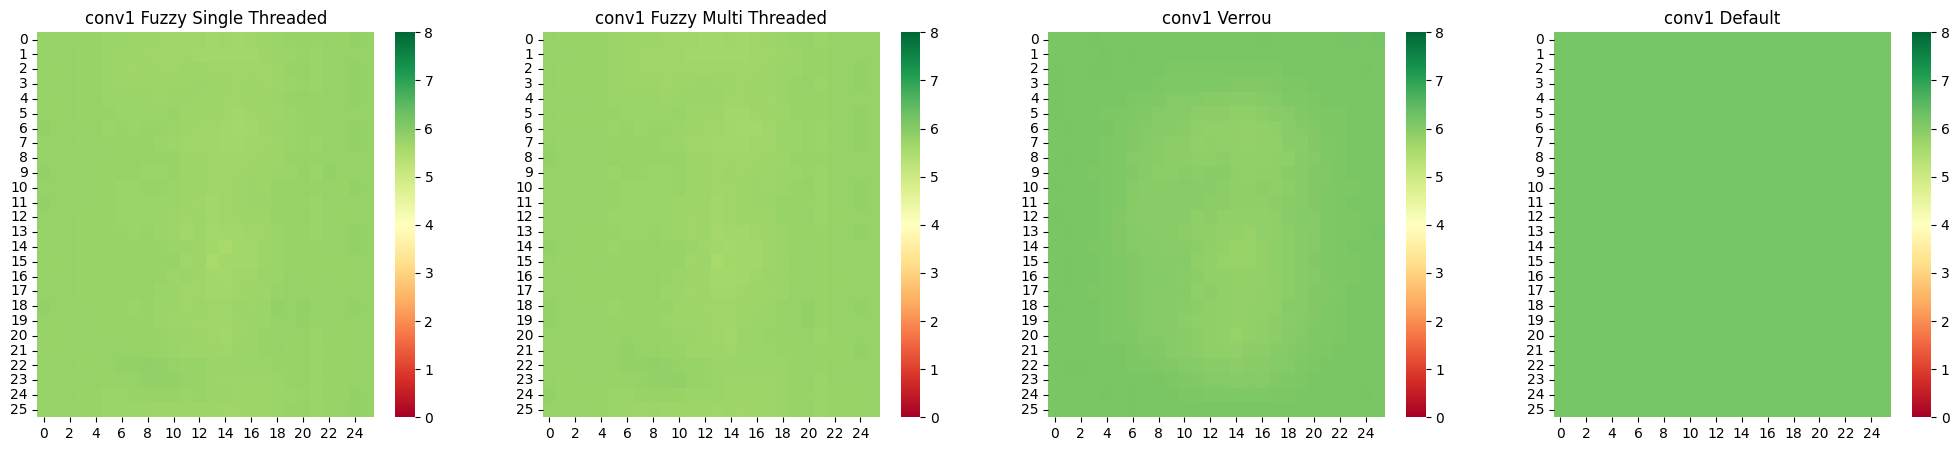

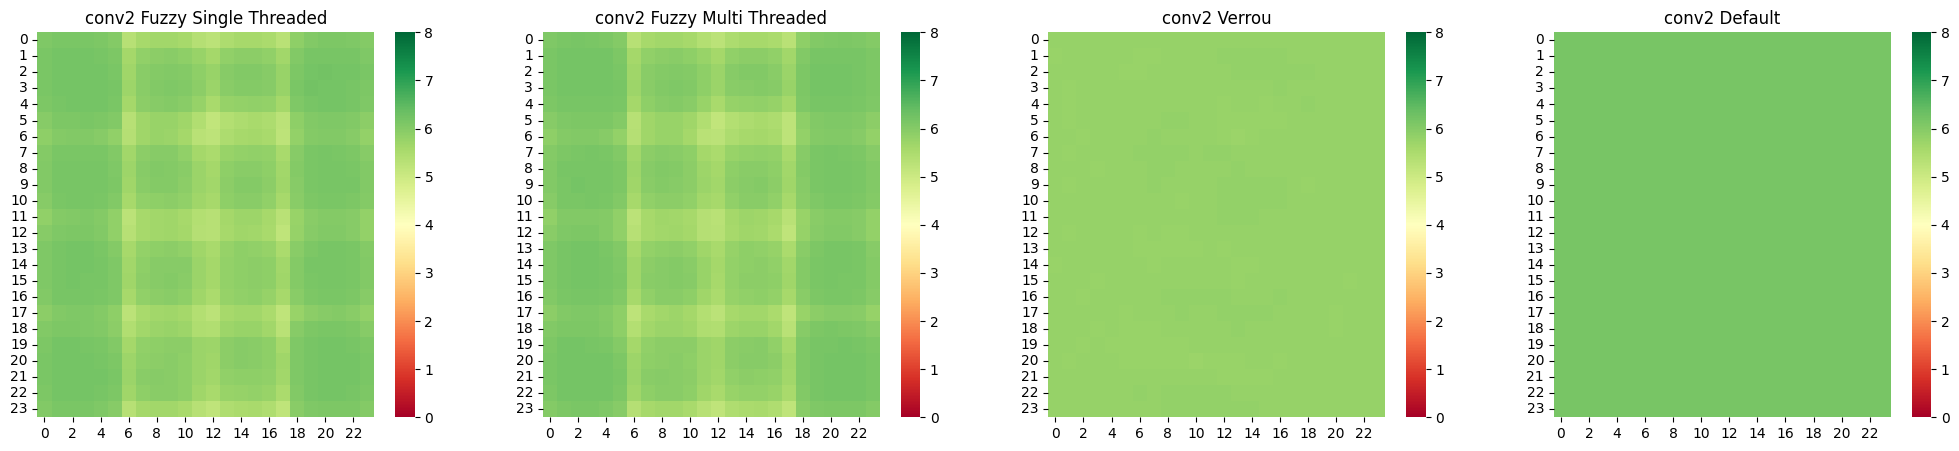

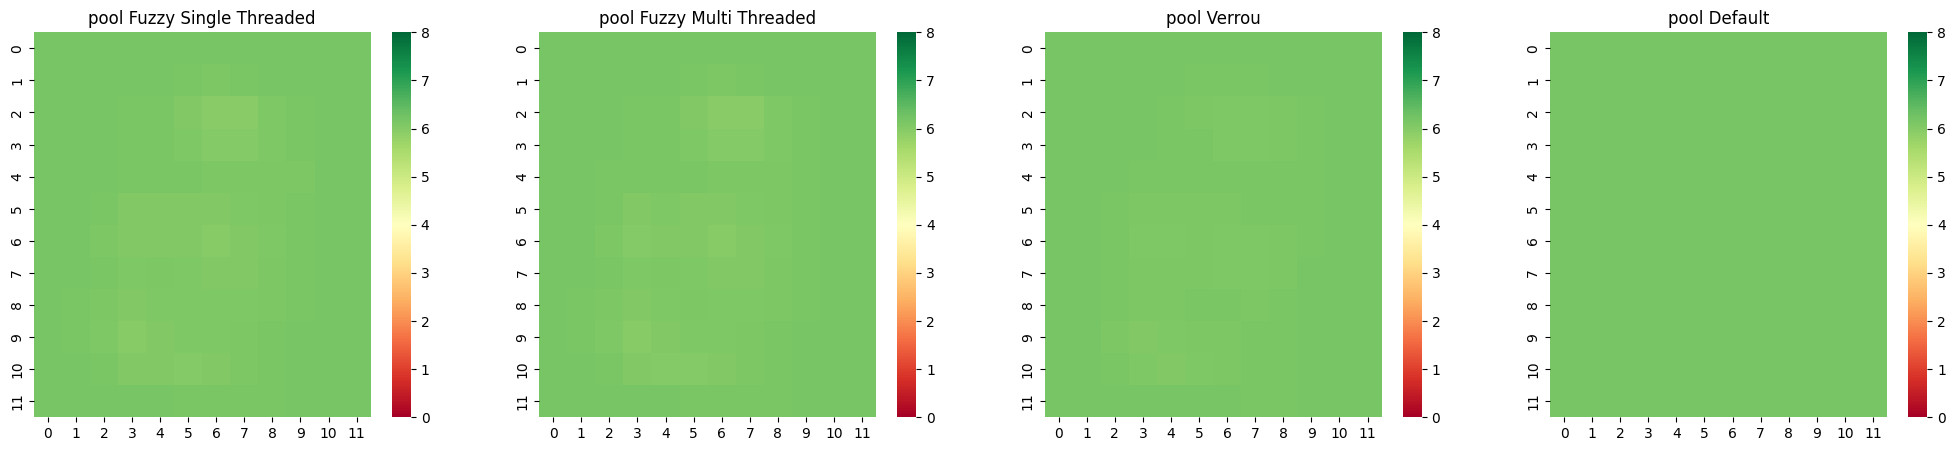

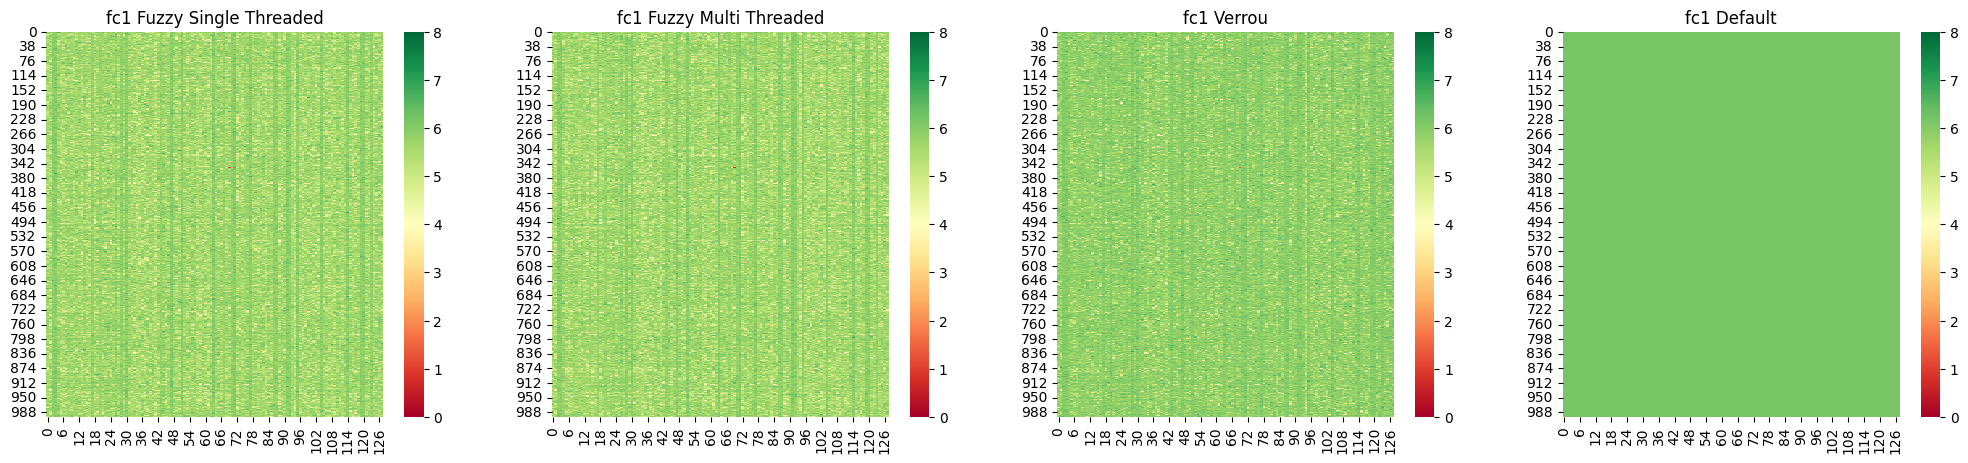

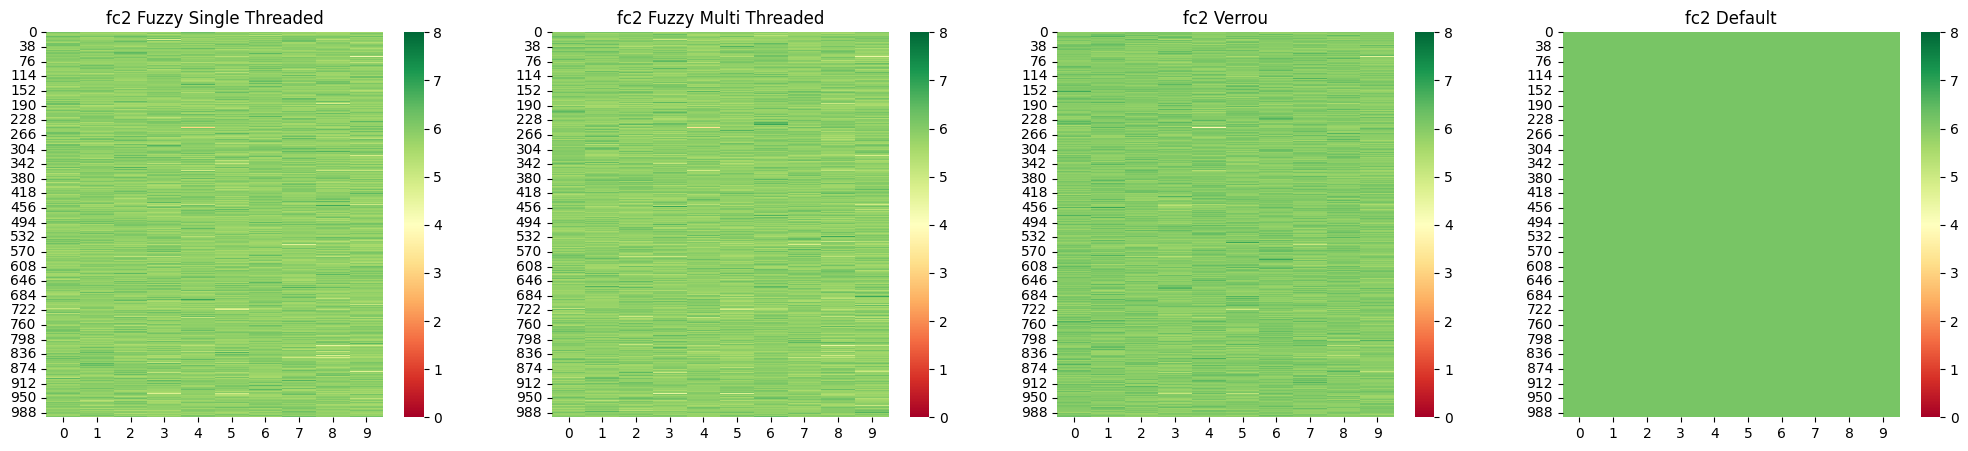

In [51]:

for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:
# for layer in ['fc1', 'fc2']:
    embed_fuzzy_singlethread = []
    embed_fuzzy_multithread = []
    embed_verrou = []
    embed_default = []
    for i in range(1,6):
        embed_fuzzy_singlethread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_multithread.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_multi/{layer}_{i}.pkl", 'rb')) )
        embed_verrou.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou/{layer}_{i}.pkl", 'rb')) )
        embed_default.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/default/{layer}_{i}.pkl", 'rb')) )
    embed_fuzzy_singlethread = torch.stack(embed_fuzzy_singlethread)
    embed_fuzzy_multithread = torch.stack(embed_fuzzy_multithread)
    embed_verrou = torch.stack(embed_verrou)
    embed_default = torch.stack(embed_default)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy single threaded
        layer_sig = sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multithreaded
        layer_sig = sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10)
        sns.heatmap(layer_sig, ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)


    else:
        #fuzzy single threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_singlethread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_singlethread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[0], cmap='RdYlGn', vmin=0, vmax=8)
        #fuzzy multi threaded
        layer_sig = np.mean(sd.significant_digits(embed_fuzzy_multithread.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_multithread, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[1], cmap='RdYlGn', vmin=0, vmax=8)
        #verrou
        layer_sig = np.mean(sd.significant_digits(embed_verrou.type(dtype=torch.float32), reference=torch.mean(embed_verrou, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[2], cmap='RdYlGn', vmin=0, vmax=8)
        #IEEE
        layer_sig = np.mean(sd.significant_digits(embed_default.type(dtype=torch.float32), reference=torch.mean(embed_default, dim=0, dtype=torch.float32),  basis=10), axis=0, dtype=np.float32)
        sns.heatmap(layer_sig[0], ax=axes[3], cmap='RdYlGn', vmin=0, vmax=8)

    axes[0].set_title(f"{layer} Fuzzy Single Threaded")
    axes[1].set_title(f"{layer} Fuzzy Multi Threaded")
    axes[2].set_title(f"{layer} Verrou")
    axes[3].set_title(f"{layer} Default")
    

plt.show()

#### Embeddings from Paper

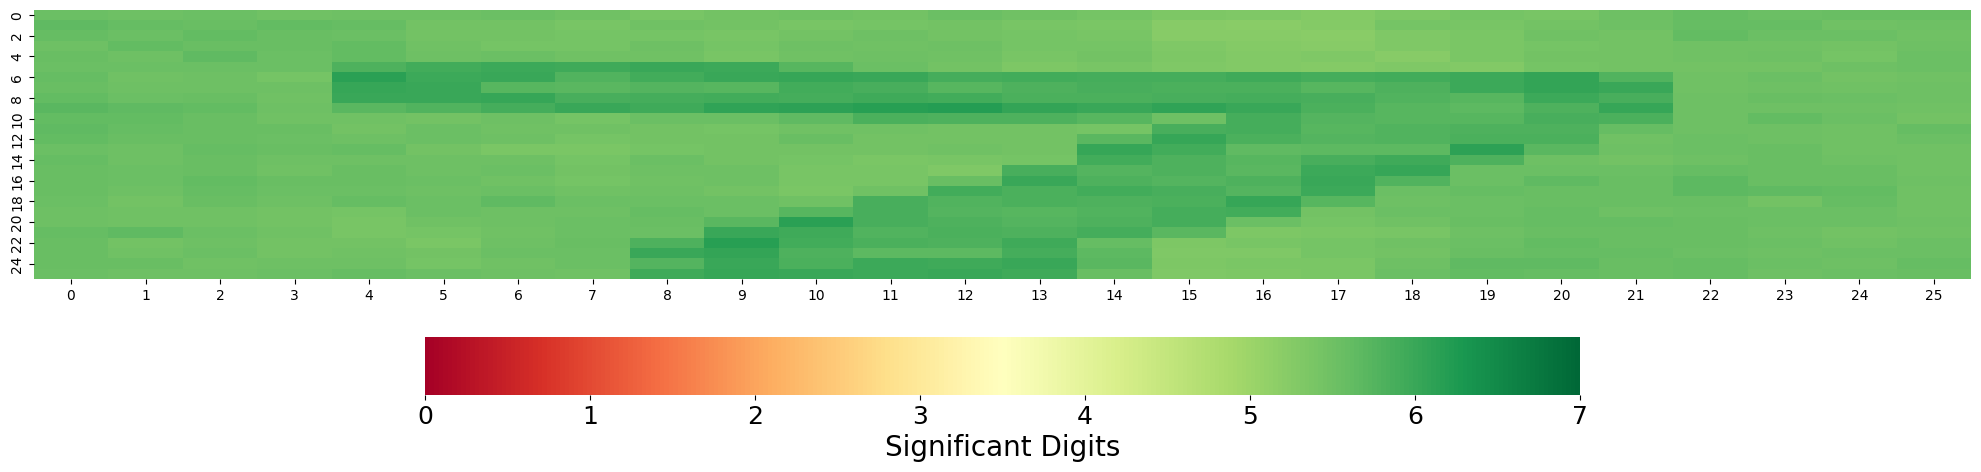

In [ ]:
for layer in ['conv1']: #, 'conv2', 'pool', 'fc1', 'fc2']:

    embed_fuzzy_ud = []


    for i in range(1,6):
        embed_fuzzy_ud.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb')) )
        
    embed_fuzzy_ud = torch.stack(embed_fuzzy_ud)
    
    fig, axes = plt.subplots(1,1, figsize=(25,5))

    #fuzzy UD
    layer_sig = sd.significant_digits(embed_fuzzy_ud.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_ud, dim=0, dtype=torch.float32),  basis=10)[0]
    g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes, cmap='RdYlGn', vmin=0, vmax=7, cbar=True, cbar_kws={"orientation": "horizontal"})
   
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set the size of the colorbar ticks
cbar.set_label('Significant Digits', size=20)  # Set the size of the colorbar label

plt.savefig(f'/home/inesgp/fuzzy-pytorch/MNIST_Use_Case/colorbar.pdf', bbox_inches='tight');

plt.show()


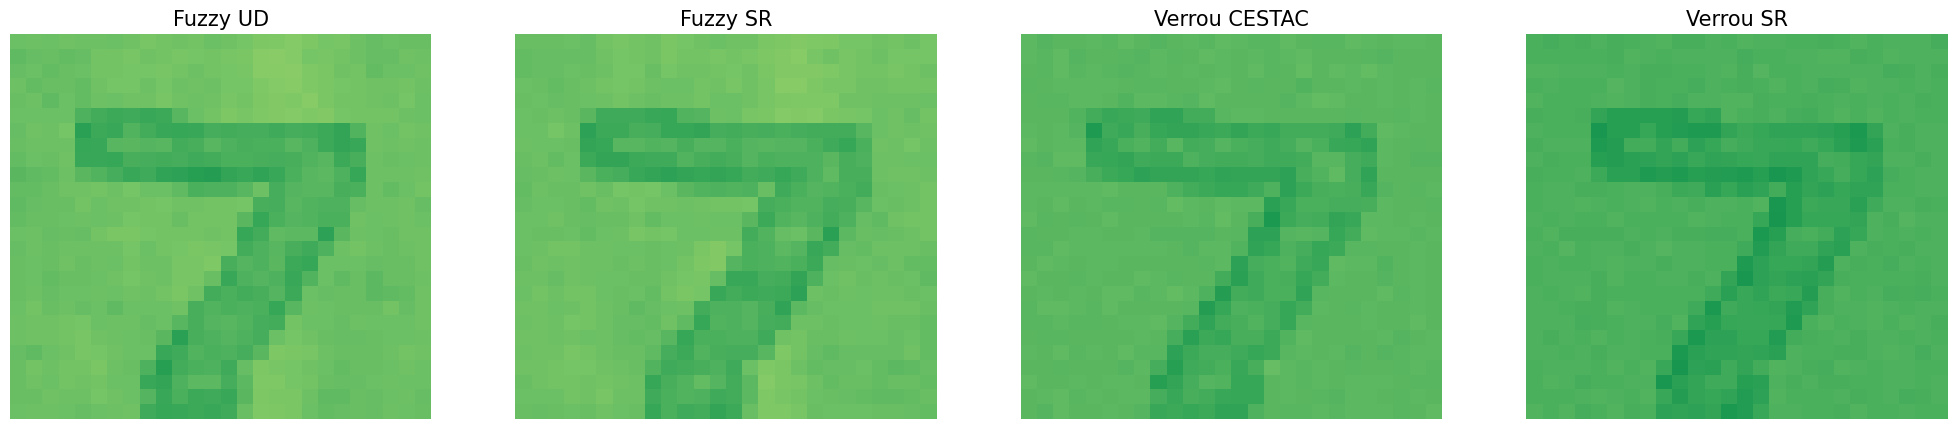

In [ ]:
for layer in ['conv1', 'conv2', 'pool', 'fc1', 'fc2']:

    # embed_fuzzy_singlethread = []
    embed_fuzzy_ud = []
    embed_fuzzy_sr = []
    embed_verrou_ud = []
    embed_verrou_sr = []

    for i in range(1,6):
        embed_fuzzy_ud.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_ud/{layer}_{i}.pkl", 'rb')) )
        embed_fuzzy_sr.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/fuzzy_sr/{layer}_{i}.pkl", 'rb')) )
        embed_verrou_ud.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou_ud_trace/{layer}_{i}.pkl", 'rb')) )
        embed_verrou_sr.append( pickle.load(open(f"/home/inesgp/mnist/embeddings/verrou_sr_trace/{layer}_{i}.pkl", 'rb')) )

    embed_fuzzy_ud = torch.stack(embed_fuzzy_ud)
    embed_fuzzy_sr = torch.stack(embed_fuzzy_sr)
    embed_verrou_ud = torch.stack(embed_verrou_ud)
    embed_verrou_sr = torch.stack(embed_verrou_sr)

    fig, axes = plt.subplots(1,4, figsize=(25,5))

    if 'fc' in layer: 
        #fuzzy UD 
        layer_sig = sd.significant_digits(embed_fuzzy_ud.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_ud, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=7, )
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy UD')
        #fuzzy SR 
        layer_sig = sd.significant_digits(embed_fuzzy_sr.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_sr, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=7)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy SR')
        #verrou UD
        layer_sig = sd.significant_digits(embed_verrou_ud.type(dtype=torch.float32), reference=torch.mean(embed_verrou_ud, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[2], cmap='RdYlGn', vmin=0, vmax=7)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou CESTAC')
        #verrou SR
        layer_sig = sd.significant_digits(embed_verrou_ud.type(dtype=torch.float32), reference=torch.mean(embed_verrou_ud, dim=0, dtype=torch.float32),  basis=10)
        g = sns.heatmap(np.expand_dims(layer_sig[0], axis=0), ax=axes[3], cmap='RdYlGn', vmin=0, vmax=7)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou SR')
    
    else:
        #fuzzy UD
        layer_sig = sd.significant_digits(embed_fuzzy_ud.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_ud, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[0], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy UD', fontsize=15)
        #fuzzy SR
        layer_sig = sd.significant_digits(embed_fuzzy_sr.type(dtype=torch.float32), reference=torch.mean(embed_fuzzy_sr, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[1], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Fuzzy SR', fontsize=15)
        #verrou UD
        layer_sig = sd.significant_digits(embed_verrou_ud.type(dtype=torch.float32), reference=torch.mean(embed_verrou_ud, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[2], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou CESTAC', fontsize=15)
        #verrou SR
        layer_sig = sd.significant_digits(embed_verrou_sr.type(dtype=torch.float32), reference=torch.mean(embed_verrou_sr, dim=0, dtype=torch.float32),  basis=10)[0]
        g = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float32), ax=axes[3], cmap='RdYlGn', vmin=0, vmax=7, cbar=False)
        g.set_yticks([]), g.set_xticks([]), g.set_title('Verrou SR', fontsize=15)
        break
        
    # axes[0].set_title(f"{layer} Fuzzy Single Threaded")
    # axes[1].set_title(f"{layer} Verrou")
    # break

plt.savefig(f'/home/inesgp/fuzzy-pytorch/MNIST_Use_Case/mnist_embeddings.pdf', bbox_inches='tight');
plt.show()

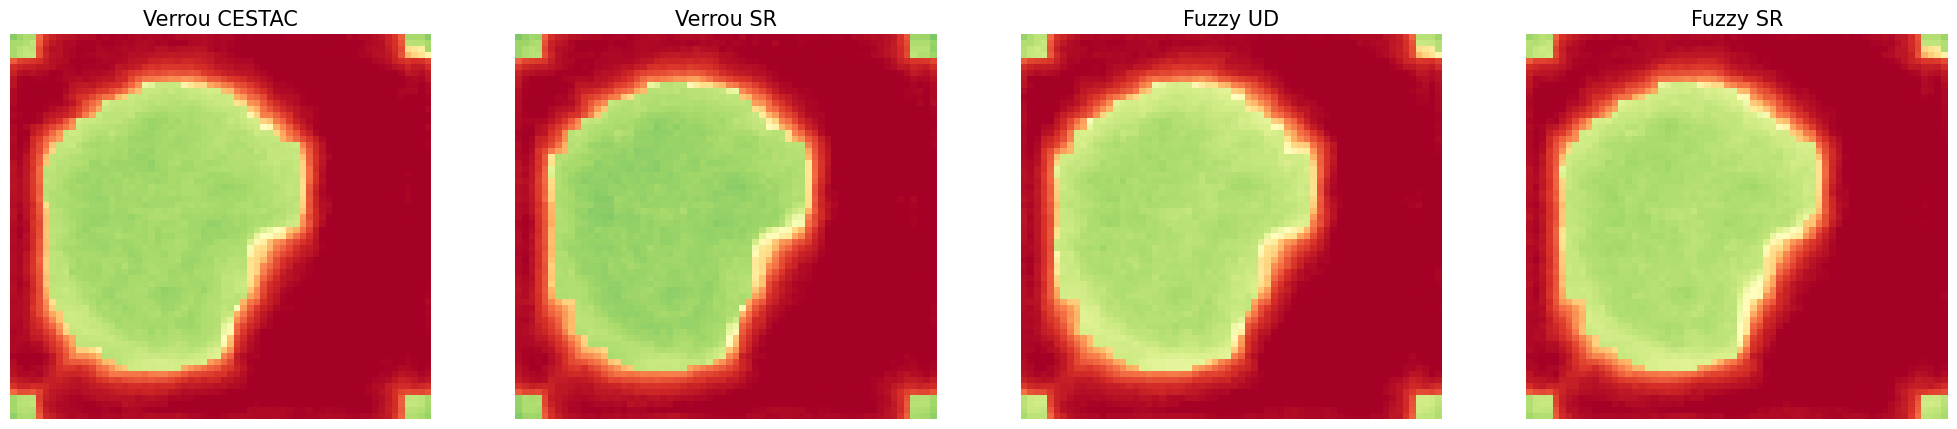

In [ ]:
embed_verrou_ud = []
embed_verrou_sr = []
embed_fuzzy_ud = []
embed_fuzzy_sr = []
embed = []

for i in range(1,6):
    embed_verrou_ud.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/verrou_ud/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    embed_verrou_sr.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/verrou_sr/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    embed_fuzzy_ud.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/fuzzy_ud/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )
    embed_fuzzy_sr.append( pickle.load(open(f'/home/inesgp/verrou_fastsurfer/0025531_embeddings/fuzzy_sr/sagittal_decoder_output3_{i}.pkl', 'rb')).squeeze() )

embed_verrou_ud = np.array(embed_verrou_ud)
embed_verrou_sr = np.array(embed_verrou_sr)
embed_fuzzy_ud = np.array(embed_fuzzy_ud)
embed_fuzzy_sr = np.array(embed_fuzzy_sr)

fig, axes = plt.subplots(1, 4, figsize=(25,5))

layer_sig = sd.significant_digits(embed_fuzzy_ud, reference=np.mean(embed_fuzzy_ud, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[2], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Fuzzy UD', fontsize=15)
# gc.set_title(f"Fuzzy UD\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")

layer_sig = sd.significant_digits(embed_fuzzy_sr, reference=np.mean(embed_fuzzy_sr, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[3], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Fuzzy SR', fontsize=15)
# gc.set_title(f"Fuzzy SR\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")


layer_sig = sd.significant_digits(embed_verrou_ud, reference=np.mean(embed_verrou_ud, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[0], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Verrou CESTAC', fontsize=15)
# gc.set_title(f"Verrou UD\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")

layer_sig = sd.significant_digits(embed_verrou_sr, reference=np.mean(embed_verrou_sr, axis=0, dtype=np.float64), basis=10, dtype=np.float64)
gc = sns.heatmap(np.mean(layer_sig, axis=0, dtype=np.float64), ax=axes[1], vmin=0, vmax=7, cmap='RdYlGn', cbar=False)
gc.set_yticks([]), gc.set_xticks([]), gc.set_title('Verrou SR', fontsize=15)
# gc.set_title(f"Verrou SR\nSignificant Digits\nMax: {np.max(layer_sig):.2f} and Min: {np.min(layer_sig):.2f}")

plt.savefig(f'/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fastsurfer_embeddings.pdf', bbox_inches='tight');


## FastSurfer Variability
**TO DO**
* Run 5 more subjects for 
    * fuzzy singlethread 
    * default
* Get dice scores
* Do entropy maps

### Dice Scores
* Calculated using Freesurfer v7.3.1 [```mri_seg_overlap```](https://surfer.nmr.mgh.harvard.edu/fswiki/mri_overlap)

**Comments on missing ROIs**
* Left-Pallidum (small speck in sagittal view)               
* 4th-Ventricle (small speck in sagittal view)
* Left-Amygdala (bit larger compute how much space it takes up only properly visible in coronal view ) 
* Right-Cerebellum-White-Matter (tiny speck barely visible in sagittal -- only properly visible in certain subjects where the slice appears differently) 
* Right-Cerebellum-Cortex (tiny speck barely visible in sagittal -- only properly visible in certain subjects where the slice appears differently)
* Left-Inf-Lat-Vent (small speck in sagittal view)  
* Right-Putamen (missing for 1 subjects where cut is different)     
* Right-Pallidum (missing for 1 subjects where cut is different)
* Right-Amygdala (only appears for some subjects )
* Right-Accumbens-area (small speck in sagittal view)

In [32]:
def pad_list(input_list):
    # Check if the length of the list is less than 10
    while len(input_list) < 10:
        input_list.append(np.nan)  # Append NaN until the length is 10
    return input_list


def dice_score_aggregator(file_dir):

    names = {
        "ID": "int",
        "Label name": "str",
        "Red": "int",
        "Green": "int",
        "Blue": "int",
        "Alpha": "int",
    }

    df = pd.read_csv(
        '/home/inesgp/verrou_fastsurfer/FreeSurferColorLUT.txt',
        sep='\s+',
        index_col=0,
        skip_blank_lines=True,
        comment="#",
        header=None,
        names=names.keys(),
        dtype=names,
    )

    df['ID'] = df.index
    df['ID'] = df['ID'].astype(str)

    name_scheme = df.set_index('ID')['Label name'].to_dict()



    aggregated_data_min = {}
    # for sub in ['0003002', '0025011', '0025350', '0025531']:
    for sub in ['0003002', '0025011', '0025248', '0025350', '0025531']:
        aggregated_data = {}

        aggregated_data_min[sub] = {}

        n=5
        for i in range(1, n + 1):
            for j in range(i, n + 1):
                if i == j: continue
                # if i ==4 and j==5: continue
                f = open(f"{file_dir}{sub}_{i}_{j}.json", 'r')
                data = json.load(f)

                # print(data['measures']['dice']['labels'])
                # print(data['names'])

                # Aggregate the values from data['measures']['dice']['labels']
                labels = data['measures']['dice']['labels']
                if labels:
                    for label, dice_scores in labels.items():
                        # If the label is not already in the aggregated_data, initialize it as an empty list
                        if label not in aggregated_data:
                            aggregated_data[label] = []

                        # Append the value to the list for this label
                        aggregated_data[label].append(dice_scores)

                        # if label == '47': print(label, sub, i, j)

        for i in aggregated_data:
            if len(aggregated_data[i]) != 10: aggregated_data[i] = pad_list(aggregated_data[i])
            # print( len(aggregated_data[i]), i )

        df = pd.DataFrame(aggregated_data)
        df = df.rename(columns=name_scheme)
        
        for col in df.columns:
            aggregated_data_min[sub][col] = [ df[col].min() ]


    dice_df = pd.DataFrame([])
    for sub in aggregated_data_min.keys():
        df = pd.DataFrame(aggregated_data_min[sub])
        dice_df = pd.concat([dice_df, df])
        dice_df = dice_df.rename(index={0:f"sub-{sub}"})

    dice_df['subjectID'] = dice_df.index

    # dice_df = dice_df.drop('subjectID', axis=1)

    dice_df = dice_df.reset_index(drop=True)
    dice_df = dice_df.fillna(0)

    return dice_df

fuzzy_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_ud/')
fuzzy_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/fuzzy_sr/')
verrou_ud_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_ud/')
verrou_sr_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/verrou_sr/')
default_dice_df = dice_score_aggregator(file_dir='/home/inesgp/verrou_fastsurfer/dice_scores/ieee/')

default_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/default_min_dice_scores.csv', index=False)
fuzzy_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fuzzy_ud_min_dice_scores.csv', index=False)
fuzzy_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/fuzzy_sr_min_dice_scores.csv', index=False)
verrou_ud_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/verrou_ud_min_dice_scores.csv', index=False)
verrou_sr_dice_df.to_csv('/home/inesgp/fuzzy-pytorch/FastSurfer_Use_Case/verrou_sr_min_dice_scores.csv', index=False)


In [28]:
len(['Left-Thalamus', 'Left-Caudate', 'Left-Putamen', '3rd-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Cerebral-White-Matter', 'CSF', 'Left-Accumbens-area',
 'Left-VentralDC', 'Left-Cerebral-Cortex', 'Left-choroid-plexus', 'Left-Lateral-Ventricle', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent',
 'Right-Thalamus', 'Right-Caudate', 'Right-Hippocampus', 'Right-VentralDC', 'Right-choroid-plexus', 'Left-Cerebellum-White-Matter', 'WM-hypointensities', 
 'Left-Cerebellum-Cortex', 'Right-Cerebral-Cortex', '4th-Ventricle', 'Left-Pallidum', 'Left-Amygdala', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex',
 'Left-Inf-Lat-Vent', 'Right-Putamen', 'Right-Pallidum', 'Right-Amygdala','Right-Accumbens-area',
 ])


# ['4th-Ventricle','Left-Pallidum', 'Left-Amygdala', 
#  'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 
#  'Left-Inf-Lat-Vent', 'Right-Putamen', 'Right-Pallidum', 
#  'Right-Amygdala', 'Right-Accumbens-area' ]


35

In [62]:
def graph_dice(df, fig, color, symbol, label, lower=True, legend=True):

    long_df = df.melt(id_vars=['subjectID'], var_name='ROI', value_name='Sorensen Dice Scores')

    # List of all ROIs
    all_rois = [
        'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', '3rd-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 
        'Left-Cerebral-White-Matter', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-Cerebral-Cortex', 
        'Left-choroid-plexus', 'Left-Lateral-Ventricle', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 
        'Right-Inf-Lat-Vent', 'Right-Thalamus', 'Right-Caudate', 'Right-Hippocampus', 'Right-VentralDC', 
        'Right-choroid-plexus', 'Left-Cerebellum-White-Matter', 'WM-hypointensities', 'Left-Cerebellum-Cortex', 
        'Right-Cerebral-Cortex', '4th-Ventricle', 'Left-Pallidum', 'Left-Amygdala', 'Right-Cerebellum-White-Matter', 
        'Right-Cerebellum-Cortex', 'Left-Inf-Lat-Vent', 'Right-Putamen', 'Right-Pallidum', 'Right-Amygdala',
        'Right-Accumbens-area'
    ]

    if lower:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df[long_df['Sorensen Dice Scores'] <= 0.1]
            .groupby('ROI')['Sorensen Dice Scores']
            .mean()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        # df = pd.DataFrame({'ROI': aligned_scores.index, 'Sorensen Dice Score': aligned_scores.values})
        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values })

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=legend,
            ),
            row=1, col=1
        )

        # Update y-axis to display ROI categories
        fig.update_yaxes(
            tickvals=y_numerical,  # Original numerical indices
            ticktext=categories,  # Corresponding category names
            tickfont=dict(size=15)  # Set the font size for y-axis ticks
        )

    else:

        # Align Sorensen Dice Scores with all ROIs, filling missing values with NaN
        x_values = (
            long_df[long_df['Sorensen Dice Scores'] >= 0.8]
            .groupby('ROI')['Sorensen Dice Scores']
            .mean()  # Or use another aggregation function like `.max()` or `.first()`
        )

        # Initialize aligned_scores with NaN
        aligned_scores = pd.Series(index=all_rois, data=np.nan)
        # Reindex x_values to match aligned_scores and update
        aligned_scores.update(x_values.reindex(aligned_scores.index))

        jitter_strength = 0.3  # Adjust this value to control jitter amount
        jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(aligned_scores.values))
        y_numerical, categories = pd.factorize(aligned_scores.index)  # Convert ROI to numerical indices

        y_with_jitter = y_numerical + jitter


        df = pd.DataFrame({'ROI': y_with_jitter, 'Sorensen Dice Score': aligned_scores.values})

        fig.add_trace(
            go.Scatter(
                x=df['Sorensen Dice Score'],
                y=df['ROI'],
                mode='markers',
                marker=dict(
                    color=color,
                    opacity=0.75,
                    size=10,
                    symbol=symbol,
                ),
                name=label,
                showlegend=False,
            ),
            row=1, col=2
        )



fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing=0.0)

#Harmonize colors + markers with Yohan's Harmonic figure
# color_map = {
#     "PRISM": px.colors.qualitative.Plotly[0],  # blue
#     "VERROU": px.colors.qualitative.Plotly[4],  # red
#     "CADNA": px.colors.qualitative.Plotly[2],  # green
#     "IEEE": px.colors.qualitative.Plotly[3],  # yellow
#     "IEEE": px.colors.qualitative.Plotly[8],  # purple
#     "SR": px.colors.qualitative.Plotly[5],  # purple
#     "MCA": px.colors.qualitative.Plotly[1],  #
# }

graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD')
graph_dice(fuzzy_ud_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='diamond', label='Fuzzy UD', lower=False)
graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR')
graph_dice(fuzzy_sr_dice_df, fig, color=px.colors.qualitative.Plotly[0], symbol='triangle-up', label='Fuzzy SR', lower=False)
graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC')
graph_dice(verrou_ud_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='x', label='Verrou CESTAC', lower=False)
graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR')
graph_dice(verrou_sr_dice_df, fig, color= px.colors.qualitative.Plotly[4], symbol='triangle-up', label='Verrou SR', lower=False, legend=True)
# graph_dice(default_dice_df, fig, color='red', label='IEEE')

# Custom tick values and labels
custom_ticks = [-0.05, 0, 0.05, 0.1, 0.995, 1, 1.05]
custom_labels = ["-0.05", "0", "...", "", "0.995", "1", "1.05"]

# Update x-axis for both subplots with custom ticks
fig.update_xaxes(
    tickvals=custom_ticks[:4],  # First set of ticks
    ticktext=custom_labels[:4],
    range=[-0.05, 0.1],
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_text="",
    row=1,
    col=1
)

fig.update_xaxes(
    tickvals=custom_ticks[4:],  # Second set of ticks
    ticktext=custom_labels[4:],
    range=[0.995, 1.005],
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_text="",
    row=1,
    col=2
)

# Update y-axis
fig.update_yaxes(
    title_text="ROI", 
    row=1, col=1,
    tickfont=dict(size=16),  # Set a consistent font size for all ticks
    title_font=dict(size=18),  # Set the font size of the y-axis label
    automargin=True,  # Ensure enough margin for tick labels
    range=[-1,35]
    )

# Add a shared x-axis label
fig.add_annotation(
    x=0.5,
    y=-0.04,  # Adjust position for shared label (within the plot area)
    text="Sorensen Dice Scores",
    showarrow=False,
    xref="paper",
    yref="paper",
    font=dict(size=18),
)

# Layout adjustments
fig.update_layout(
    width=800,
    height=1400,
    showlegend=True,  # Show the legend
    margin=dict(l=10, r=10, t=5, b=10),
    legend=dict(
        orientation="h",  # Set legend to horizontal orientation
        yanchor="bottom",
        y=1.0,  # Position the legend above the figure
        xanchor="center",
        x=0.5,  # Center the legend horizontally
        font=dict(size=14),  # Adjust legend font size
    ),
)



fig.write_image('/home/inesgp/verrou_fastsurfer/fastsurfer_min_dice.pdf', engine="kaleido", format='pdf')


# Show the plot
fig.show()


### Entropy Maps
* **Unused for paper**
* Run ```calculate_entropy.py```

0003002


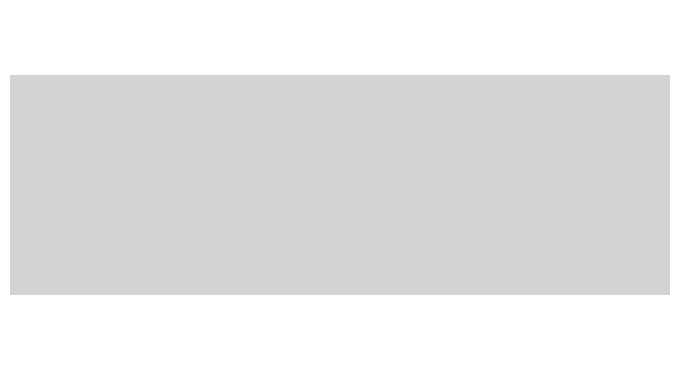

In [59]:
entropy_directory = '/mnt/lustre/inesgp/'
img_directory = '/home/inesgp/verrou_fastsurfer/'

cmap0 = LinearSegmentedColormap.from_list('', ['lightgray', 'red'])

for subject in ['0003002', ]:
    print(subject)
    # result = entropy_voxel(f'/home/inesgp/verrou_fastsurfer/sub-{subject}', sub=subject)

    img = nib.load(f"{img_directory}/sub-{subject}/{subject}_1/mri/aseg.auto_noCCseg.mgz")
    entropy = np.load(f"{entropy_directory}/entropy_maps/fuzzy_ud_{subject}.npy")

    img = nib.nifti1.Nifti1Image(entropy, img.affine) 
    display = plotting.plot_img(img, cut_coords=(0,0,30), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6) #, axes=axes[0])
    # display.savefig(f"/home/ines/Documents/Thesis/FreeSurfer/special_fig/fs_sub-0027012_entropy.png")


    # break


0003002
0025011
0025248
0025531
0003002
0025011
0025248
0025531


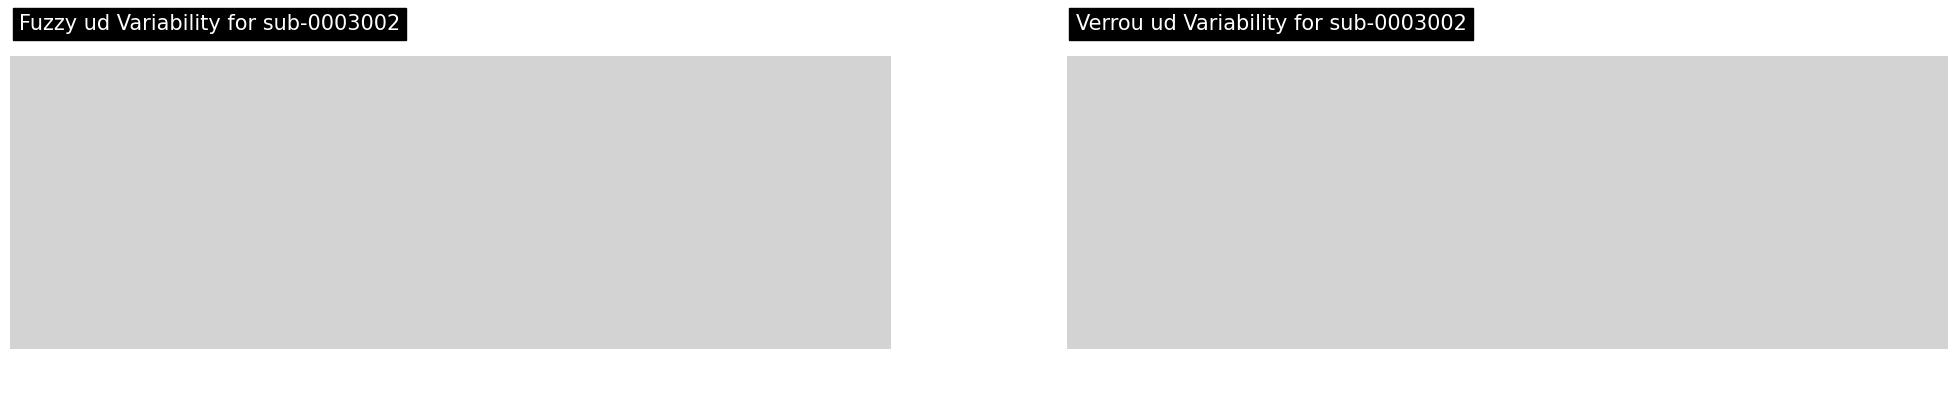

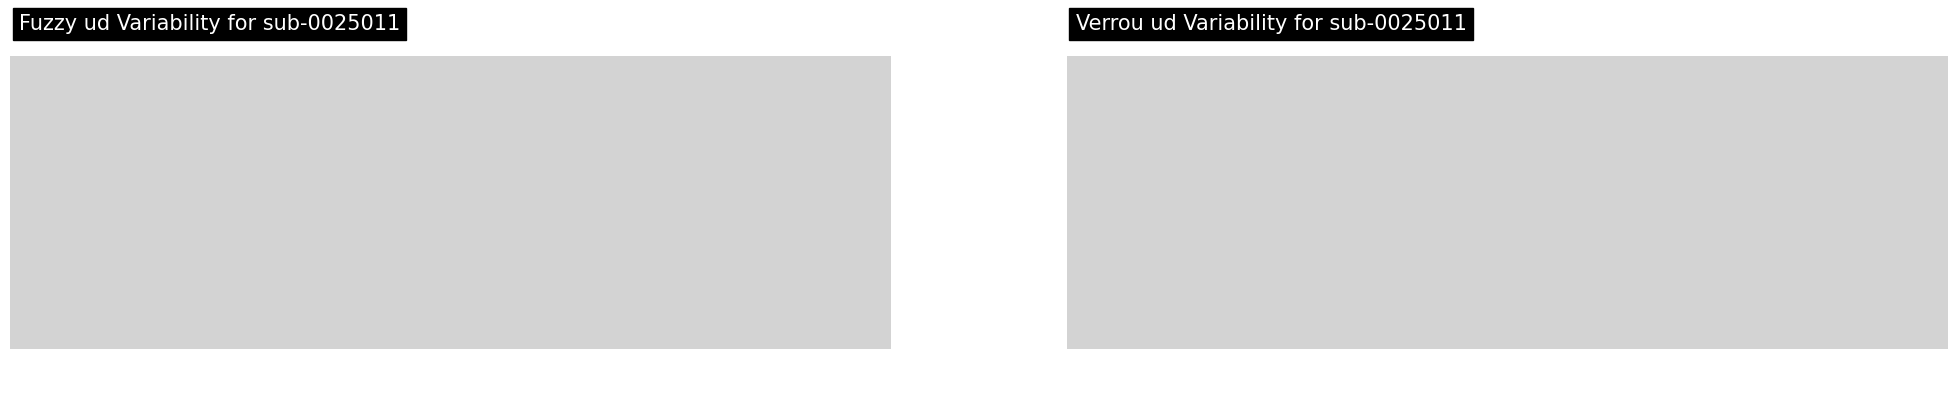

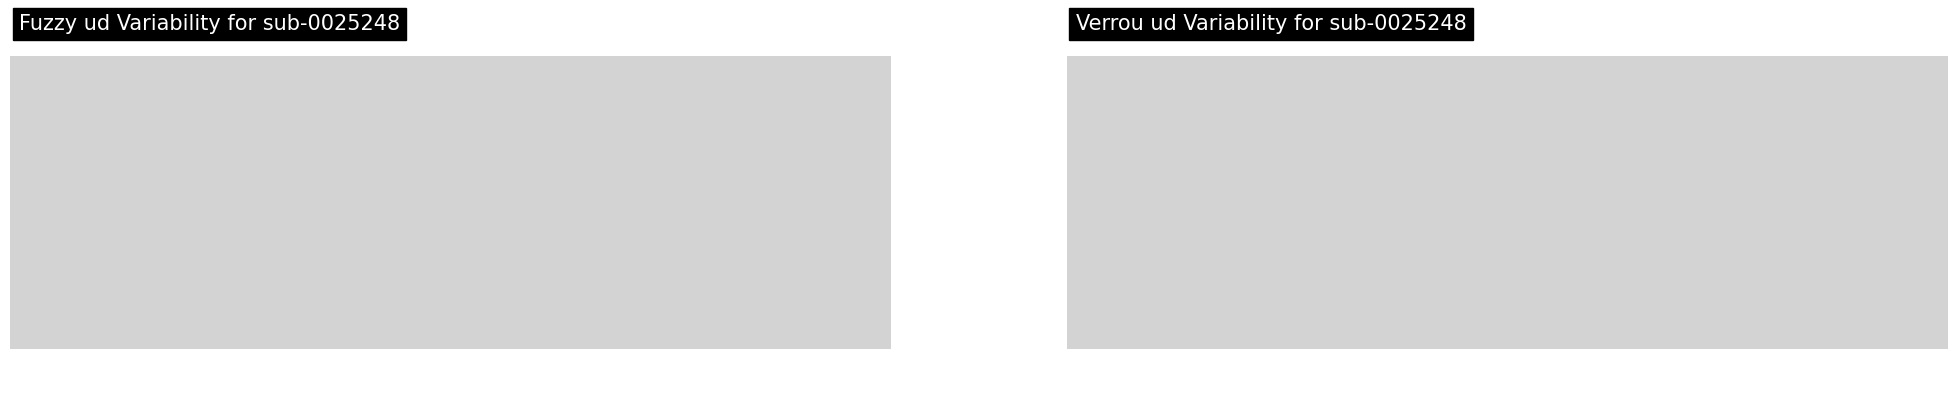

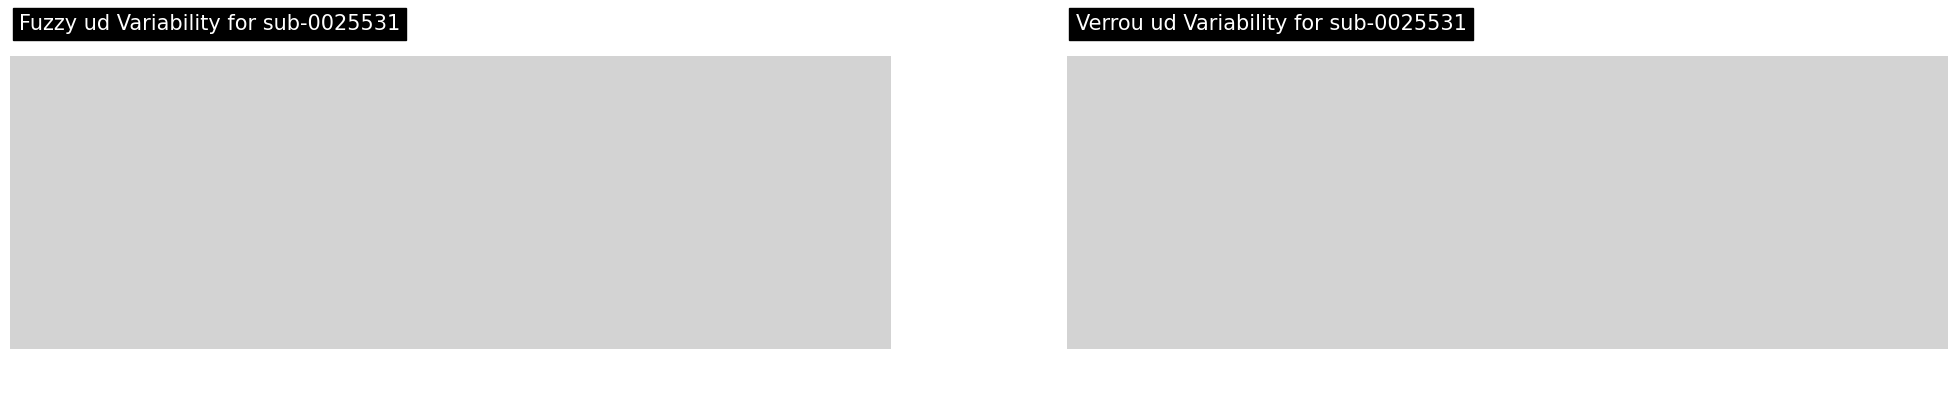

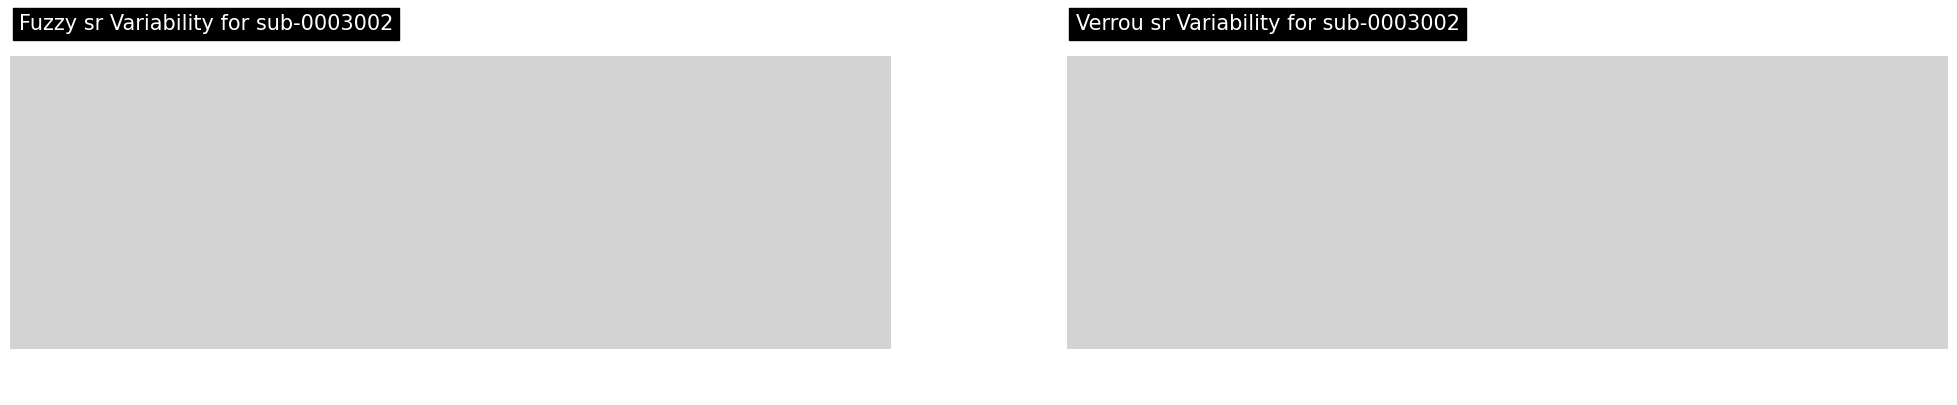

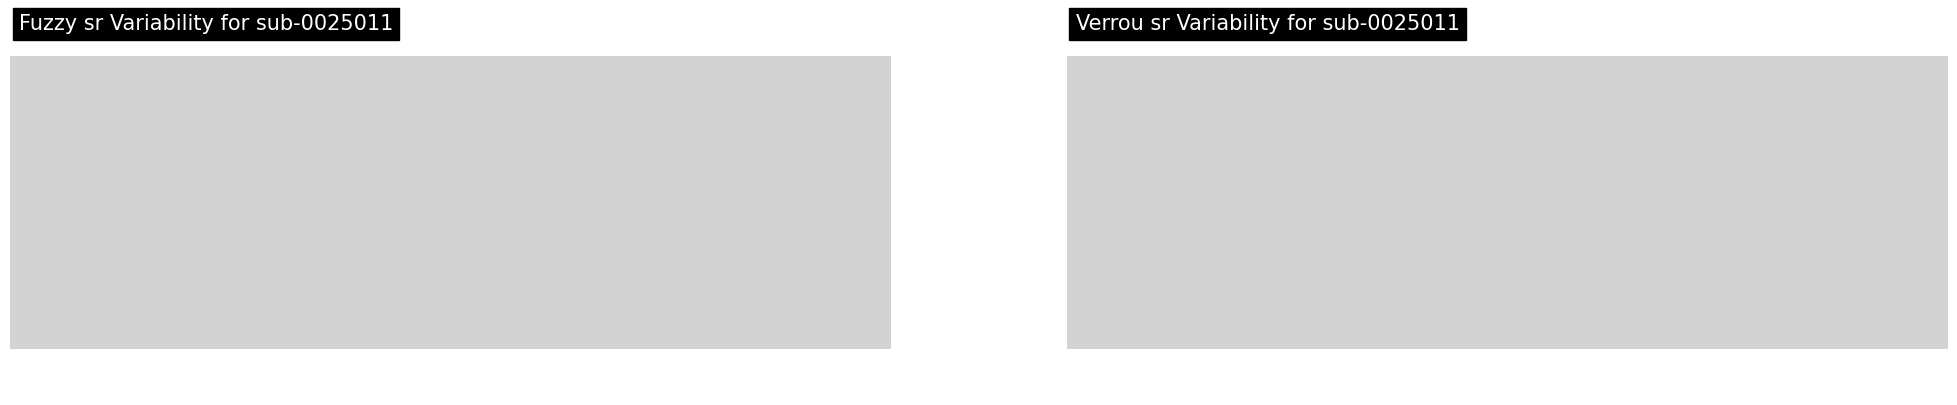

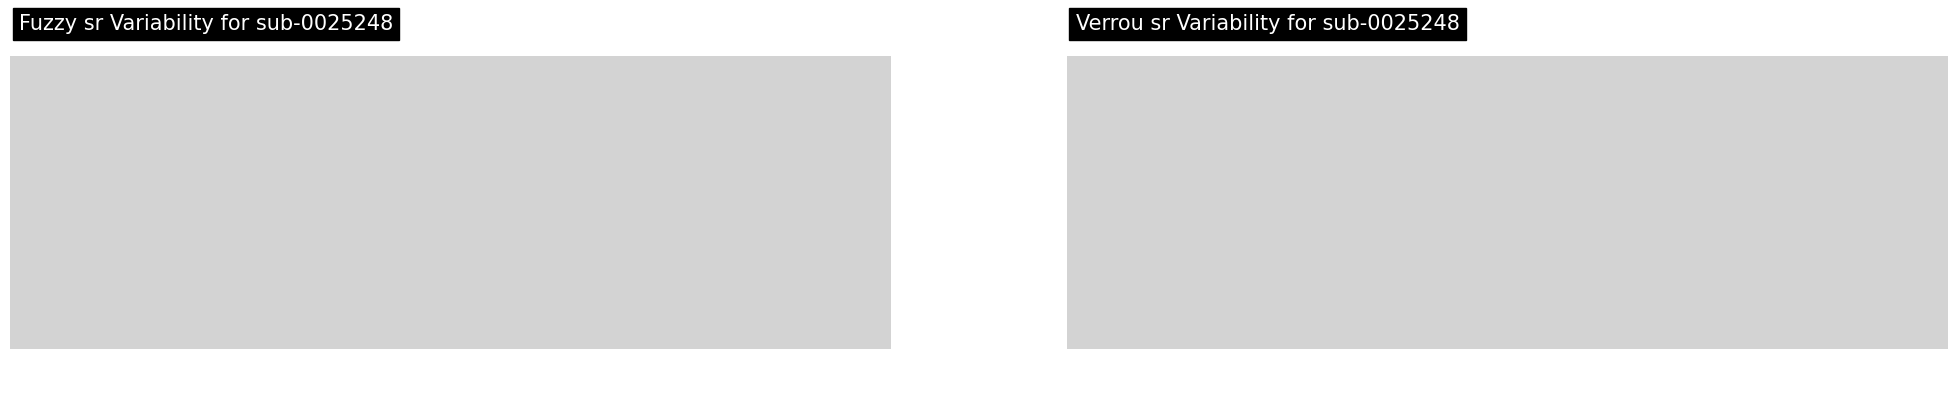

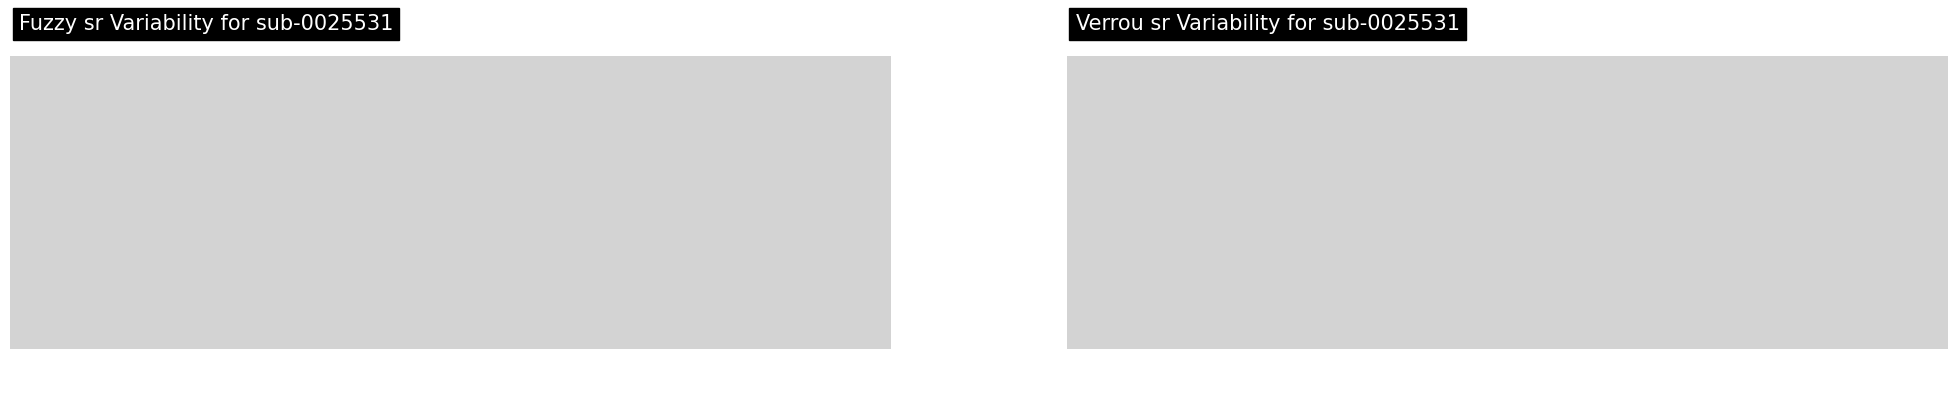

In [61]:

def graph_entropy(img_directory, entropy_directory, marker):
    cmap0 = LinearSegmentedColormap.from_list('', ['lightgray', 'red'])

    # for subject in ['0003002', '0025011', '0025248', '0025350', '0025531']:
    for subject in ['0003002', '0025011', '0025248', '0025531']:
        print(subject)

        fig, axes = plt.subplots(1,2, figsize=(25,5))
        img = nib.load(f"{img_directory}/sub-{subject}/{subject}_1/mri/aseg.auto_noCCseg.mgz")
        fuzzy_entropy = np.load(f"{entropy_directory}/entropy_maps/fuzzy_{marker}_{subject}.npy")
        # ieee_entropy = np.load(f"{entropy_directory}/entropy_maps/ieee_{subject}.npy")
        verrou_entropy = np.load(f"{entropy_directory}/entropy_maps/verrou_{marker}_{subject}.npy")

        fuzzy_img = nib.nifti1.Nifti1Image(fuzzy_entropy, img.affine)
        # ieee_img = nib.nifti1.Nifti1Image(ieee_entropy, img.affine) 
        verrou_img = nib.nifti1.Nifti1Image(verrou_entropy, img.affine)

        display = plotting.plot_img(fuzzy_img, cut_coords=(119,110,120), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6, axes=axes[0])
        display.title(f'Fuzzy {marker} Variability for sub-{subject}')
        # display = plotting.plot_img(ieee_img, cut_coords=(0,0,30), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6, axes=axes[1])
        # display.title(f'IEEE Variability for sub-{subject}')
        display = plotting.plot_img(verrou_img, cut_coords=(120,120,120), black_bg=False, draw_cross=False, bg_img=None,cmap=cmap0, annotate=False, vmin=0, vmax=1.6, axes=axes[1])
        display.title(f'Verrou {marker} Variability for sub-{subject}')
        # break


graph_entropy(img_directory='/home/inesgp/verrou_fastsurfer', entropy_directory = '/mnt/lustre/inesgp/', marker='ud')
graph_entropy(img_directory='/home/inesgp/verrou_fastsurfer', entropy_directory = '/mnt/lustre/inesgp/', marker='sr')

UD
0003002
0025011
0025248
0025350
0025531
5
SR
0003002
0025011
0025248
0025350
0025531
5


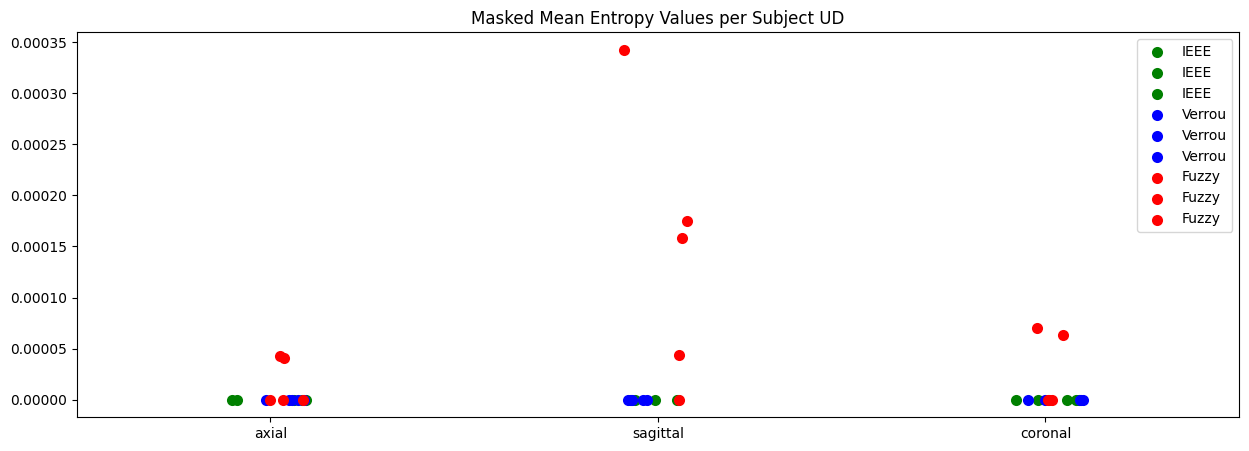

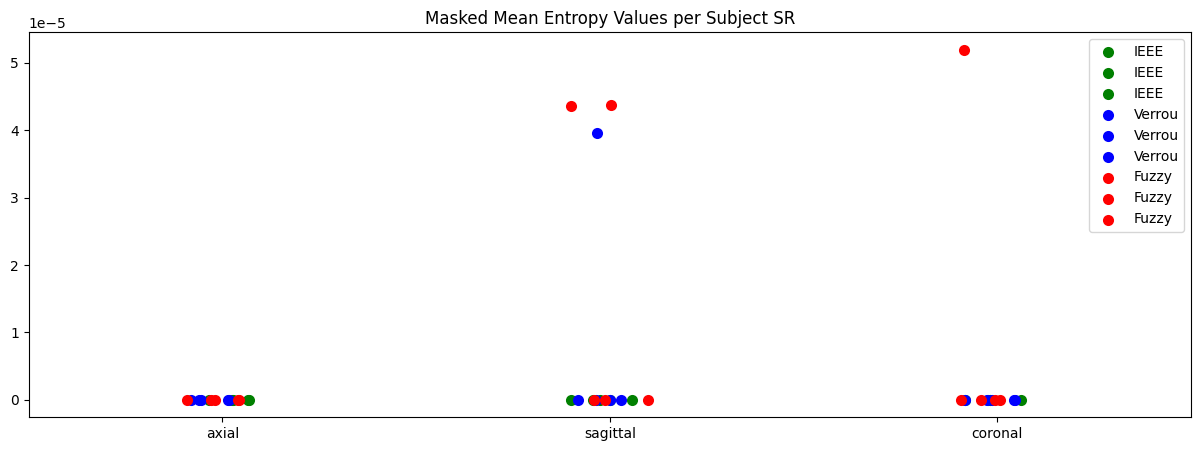

In [13]:

def graph_entropy(img_directory, entropy_directory, marker):
    cmap0 = LinearSegmentedColormap.from_list('', ['lightgray', 'red'])

    verrou_values_sagittal = []
    verrou_values_axial = []
    verrou_values_coronal = []

    fuzzy_values_sagittal = []
    fuzzy_values_axial = []
    fuzzy_values_coronal = []

    ieee_values_sagittal = []
    ieee_values_axial = []
    ieee_values_coronal = []
    
    fig, axes = plt.subplots(1,1, figsize=(15,5))

    for subject in ['0003002', '0025011', '0025248', '0025350', '0025531']:
        print(subject)

        img = nib.load(f"{img_directory}/sub-{subject}/{subject}_1/mri/aseg.auto_noCCseg.mgz")
        fuzzy_entropy = np.load(f"{entropy_directory}/entropy_maps/fuzzy_{marker}_{subject}.npy")
        ieee_entropy = np.load(f"{entropy_directory}/entropy_maps/ieee_{subject}.npy")
        verrou_entropy = np.load(f"{entropy_directory}/entropy_maps/verrou_{marker}_{subject}.npy")

        mask = img.get_fdata() != 0

        
        verrou_values_sagittal.append( verrou_entropy[120][mask[120]].mean() )
        verrou_values_axial.append( verrou_entropy[:, 120][mask[:,120]].mean() )
        verrou_values_coronal.append( verrou_entropy[:, :, 120][mask[:, :, 120]].mean() )
        # print('Verrou', 'sagittal', extracted_values_view1.mean(), 'axial', extracted_values_view2.mean(), 'coronal', extracted_values_view3.mean() )

        fuzzy_values_sagittal.append( fuzzy_entropy[120][mask[120]].mean() )
        fuzzy_values_axial.append( fuzzy_entropy[:, 120][mask[:,120]].mean() )
        fuzzy_values_coronal.append( fuzzy_entropy[:, :, 120][mask[:, :, 120]].mean() )

        ieee_values_sagittal.append( ieee_entropy[120][mask[120]].mean() )
        ieee_values_axial.append( ieee_entropy[:, 120][mask[:,120]].mean() )
        ieee_values_coronal.append( ieee_entropy[:, :, 120][mask[:, :, 120]].mean() )

    print( len(verrou_values_sagittal) )
    # axes.scatter([np.arange(len(verrou_values_sagittal)), np.arange(len(verrou_values_axial))], [verrou_values_sagittal, verrou_values_axial])



    # Create a DataFrame
    df_verrou = pd.DataFrame({'axial': verrou_values_axial, 'sagittal': verrou_values_sagittal, 'coronal': verrou_values_coronal})
    df_fuzzy = pd.DataFrame({'axial': fuzzy_values_axial, 'sagittal': fuzzy_values_sagittal, 'coronal': fuzzy_values_coronal})
    df_ieee = pd.DataFrame({'axial': ieee_values_axial, 'sagittal': ieee_values_sagittal, 'coronal': ieee_values_coronal})

    # Plot with seaborn
    sns.stripplot( data=df_ieee, jitter=True, color='green', size=8, label='IEEE' )
    sns.stripplot( data=df_verrou, jitter=True, color='blue', size=8, label='Verrou' )
    g = sns.stripplot( data=df_fuzzy, jitter=True, color='red', size=8, label='Fuzzy' )
    g.set_title(f'Masked Mean Entropy Values per Subject {marker.upper()}')
    plt.legend()



print('UD')
graph_entropy(img_directory='/home/inesgp/verrou_fastsurfer', entropy_directory = '/mnt/lustre/inesgp/', marker='ud')
print('SR')
graph_entropy(img_directory='/home/inesgp/verrou_fastsurfer', entropy_directory = '/mnt/lustre/inesgp/', marker='sr')